In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
from wavhandler import *
from utils import *

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
df_mosquitos = pd.read_csv(TEMP_DATADIR + 'mosquitos.csv', delimiter=';')

# Creating dataframes that contain PSDs for each insect class

In [3]:
# #bi_classes = ['LG_drosophila_10_09', 'LG_zapr_26_09']
# #target_names = all_6
# # /home/kalfasyan/data/insects/LG2
# # '/home/kalfasyan/data/insects/increasing dataset/'

# DATADIR = '/home/kalfasyan/data/insects/LG2/'
# target_names = os.listdir(DATADIR)
# print(target_names)

# X_names, y = get_data(filedir= DATADIR,
#                       target_names=target_names, nr_signals=np.inf, only_names=True)
dataset = Dataset('leek_leafminers')
X_names, y = dataset.load(only_names=True)

100%|██████████| 3/3 [00:00<00:00, 1353.87it/s]


In [5]:
%%time
X = make_df_parallel(names=X_names, setting='psd_dB')

CPU times: user 81.1 ms, sys: 79.1 ms, total: 160 ms
Wall time: 2.07 s


In [ ]:
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit(dataset.target_classes).inverse_transform(y)
print(y)

In [8]:
df_concat = pd.DataFrame(X)
df_concat['label'] = y
print(df_concat.label.value_counts())
df_concat = df_concat[df_concat.label.isin([target_names[0], target_names[2]])]
print(df_concat.label.value_counts())

X = df_concat.iloc[:,:-1].values
y = df_concat.label.values

ValueError: Length of values does not match length of index

/home/kalfasyan/miniconda3/envs/wingbeats/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.radviz' is deprecated, import 'pandas.plotting.radviz' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


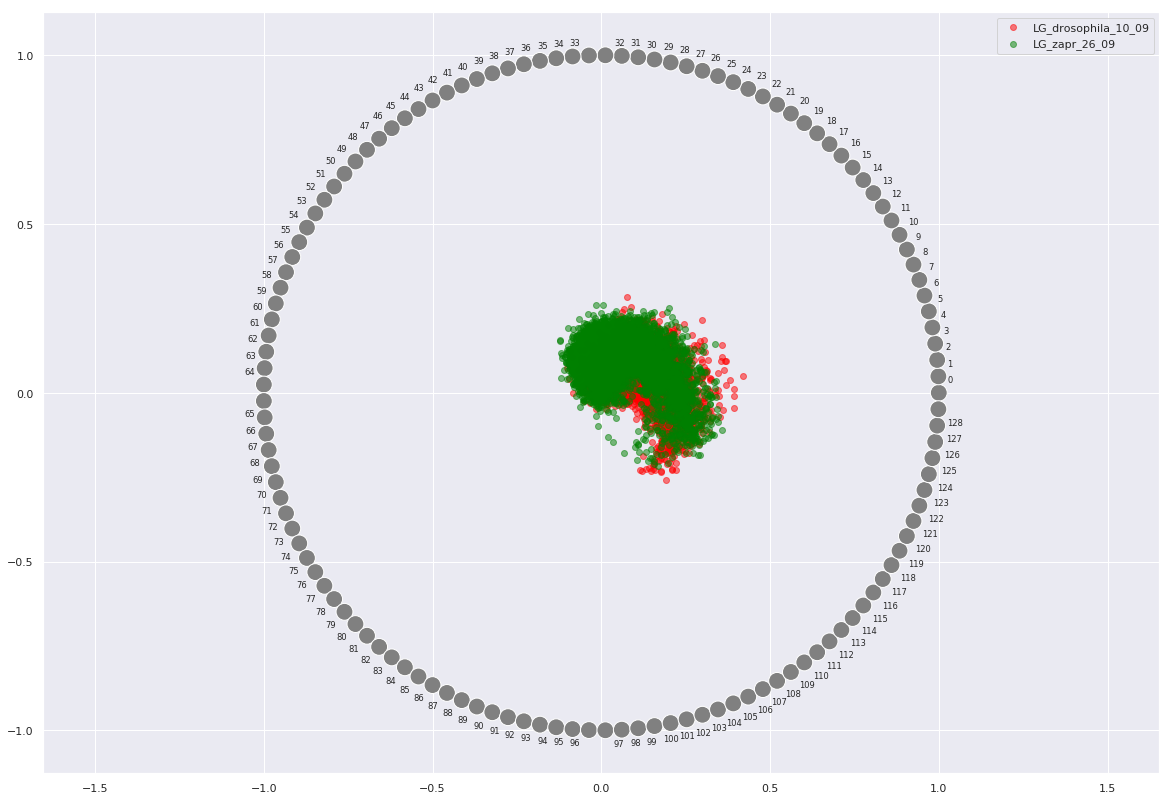

In [23]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(20,14))
radviz(df_concat,'label', color=['red','green'], alpha=0.5)
plt.show()

### Example PSD

In [153]:
# plt.plot(X[np.random.randint(0,X.shape[0]),:])

# Principal Component Analysis (short)

EXPLAINED VARIANCE with 2 components: 0.82


Text(0, 0.5, 'component 2')

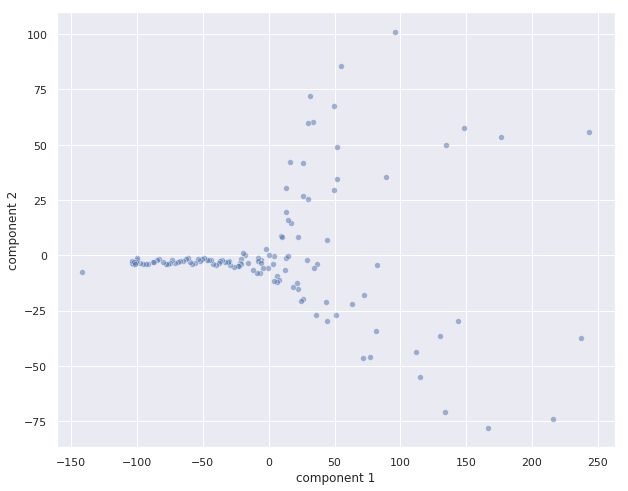

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data

ncomps = 2
pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
Χ_final = pca.fit_transform(X_std)
print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )

plt.figure(figsize=(10,8))
sns.scatterplot(Χ_final[:,0], Χ_final[:,1],alpha=0.5, legend='full') # hue=y, 
plt.xlabel('component 1')
plt.ylabel('component 2')

In [ ]:
df_pca = pd.DataFrame(pca.components_,index = ['PC-1','PC-2'])#, 'PC-3'])
df_pca

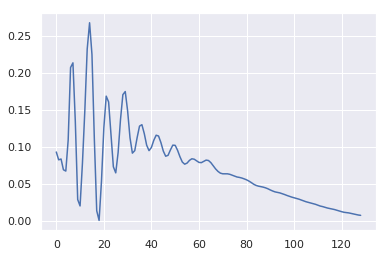

In [19]:
df_pca.loc['PC-1'].plot()

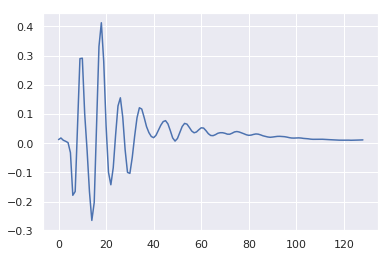

In [20]:
df_pca.loc['PC-2'].plot()

In [21]:
#df_pca.loc['PC-3'].plot()

## Principal Component Analysis (traditional)

In [ ]:
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(X)

mean_vec = np.mean(X_std, axis=0)

cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

In [ ]:
u,s,v = np.linalg.svd(X_std.T)
print(u)
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for q,i in enumerate(eig_pairs):
    print(i[0])
    if q>10:
        break

In [ ]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp = cum_var_exp[:10]
var_exp = var_exp[:10]

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(len(var_exp)), np.array(var_exp), alpha=0.5)
    plt.step(range(len(var_exp)), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(128,1),
                      eig_pairs[1][1].reshape(128,1)))

print('Matrix W:\n', matrix_w)

In [ ]:
Y = X_std.dot(matrix_w)

In [ ]:
np.unique(y)

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(20, 10))
    for lab, col in zip(('ae', 'an', 'cu'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

In [ ]:
Y

# 3D Plot (PCA scores, 3 components)

In [112]:
import plotly
import plotly.plotly as py
from sklearn.preprocessing import LabelEncoder
plotly.tools.set_credentials_file(username='kalfasyan', api_key='oOr9ILFmszXQYREloJTp')

import plotly.graph_objs as go

import numpy as np

x, y, z = Χ_final[:,0], Χ_final[:,1], Χ_final[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',#LabelEncoder().fit(target_names).transform(df_concat.label.tolist()),#
            colorscale='Portland',
            width=0.5
        ),
        opacity=0.9
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

/home/kalfasyan/miniconda3/envs/wingbeats/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(Χ_final)


import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='kalfasyan', api_key='oOr9ILFmszXQYREloJTp')

import plotly.graph_objs as go

import numpy as np

x, y, z = Χ_final[:,0], Χ_final[:,1], Χ_final[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=1,
        line=dict(
            color=kmeans.labels_,#'rgba(217, 217, 217, 0.14)',
            colorscale='Viridis',
            width=0.5
        ),
        opacity=0.9
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [ ]:
df_an = df_an.transpose()
df_an.shape

In [ ]:
df_an['kmeans'] = kmeans.labels_

In [ ]:
df_an.sample(10)

In [ ]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
save_obj(df_an['kmeans'].to_dict(), 'df_an_clusters')